# PDEs 3 Workshop 3

Welcome to the third workshop of the PDE 3 (Numerical) course!

## In this workshop:

* Matrix Methods
* Grid Convergence

In [1]:
# Run this cell to import the required modules.
# Do this before you write any code!

import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from scipy.optimize import curve_fit

Here, we implement the `Grid` class which we have used before in Workshop 2. We will need this later.

You don't need to understand the code written here but you can take a look if you would like to.

In [2]:
# Run this cell before continuing
class Grid:
    """A class defining a 2D grid on which we can implement the Jacobi, SOR and matrix schemes."""

    def __init__(self, ni: int, nj: int):
        self.ni = ni
        self.nj = nj
        self.origin = (0.0, 0.0)
        self.extent = (1.0, 1.0)

        self.u = np.zeros((ni, nj))
        self.x = np.zeros((ni, nj))
        self.y = np.zeros((ni, nj))
    
    def set_origin(self, x0: float, y0: float):
        """Set the origin of the grid."""
        self.origin = (x0, y0)

    def set_extent(self, x1: float, y1: float):
        """Set the extent of the grid."""
        self.extent = (x1, y1)

    def Delta_x(self) -> float:
        """The spacing in the x-direction."""
        return (self.extent[0] - self.origin[0]) / (self.ni - 1)
    
    def Delta_y(self) -> float:
        """The spacing in the y-direction."""
        return (self.extent[1] - self.origin[1]) / (self.nj - 1)
    
    def generate(self, Quiet: bool = True):
        '''generate a uniformly spaced grid covering the domain from the
        origin to the extent.  We are going to do this using linspace from
        numpy to create lists of x and y ordinates and then the meshgrid
        function to turn these into 2D arrays of grid point ordinates.'''
        x_ord = np.linspace(self.origin[0], self.extent[0], self.ni, endpoint=True)
        y_ord = np.linspace(self.origin[1], self.extent[1], self.nj, endpoint=True)
        self.x, self.y = np.meshgrid(x_ord, y_ord)
        self.x = np.transpose(self.x)
        self.y = np.transpose(self.y)

        if not Quiet:
            print(self)
    
    def __str__(self):
        """A quick function to tell us about the grid. This will be what is displayed if you try to print the Grid object."""
        return f"Grid Object: Uniform {self.ni}x{self.nj} grid from {self.origin} to {self.extent}."

# Section 1:
 In this question, we will use the Laplace equation to model the electric potential in a region of space surrounded by charged plates. The Laplace equation is given by:

$$
V_{xx} + V_{yy} = 0.
$$

As explained in the lectures, we can start with the central finite difference approximation of the Laplace equation:
$$V_{i,j}=\frac{V_{i-1,j}+V_{i+1,j}+\beta^2\left(V_{i,j-1}+V_{i,j+1}\right)}{2(1+\beta^2)}.$$
Here, we have taken a more general case where $\beta=\frac{\Delta x}{\Delta y}$.
In the lectures, the case where $\beta=1$ was considered.

### a)
Re-arrange (by hand) the finite difference approximation into the form 
$$r_y V_{i,j-1} + r_x V_{i-1,j} +  V_{i,j}  + r_x V_{i+1,j}  + r_y V_{i,j+1} = 0$$
and hence find the coefficients $r_x$ and $r_y$.

<font color='orange'>Your answer goes here. Double-click the cell to modify it.</font>

<font color='red'>

### Solution:

We have $$V_{i,j}=\frac{V_{i-1,j}+V_{i+1,j}+\beta^2\left(V_{i,j-1}+V_{i,j+1}\right)}{2(1+\beta^2)},$$

taking everything onto the LHS gives:

$$V_{i,j}-\frac{V_{i-1,j}+V_{i+1,j}+\beta^2\left(V_{i,j-1}+V_{i,j+1}\right)}{2(1+\beta^2)}=0$$

so then splitting out individual terms:

$$V_{i,j}-\frac{1}{2(1+\beta^2)}V_{i-1,j}-\frac{1}{2(1+\beta^2)}V_{i+1,j}-\frac{\beta^2}{2(1+\beta^2)}V_{i,j-1}-\frac{\beta^2}{2(1+\beta^2)}V_{i,j+1}=0$$

and so by inspection, we have

$$
r_x = -\frac{1}{2(1+\beta^2)} \quad \text{and} \quad r_y = -\frac{\beta^2}{2(1+\beta^2)}
$$

</font>

### b)

Create a function called `determine_coefficients` that takes in a `Grid` object and returns the coefficients $r_x$ and $r_y$ as a tuple.

[Hint: You can use the `Grid.Delta_x()` and `Grid.Delta_y()` methods to find the grid spacing. To return a tuple, you can use a round bracket, given by `return (r_x, r_y)`]

In [3]:
def determine_coefficients(mesh: Grid) -> tuple[float, float]:
    """Determine the coefficients r_x and r_y to assemble the matrix for the Laplace equation.

    Parameters
    ----------

    mesh : Grid
        The mesh on which we are solving the Laplace equation.
    
    Returns
    -------

    (r_x, r_y) : tuple[float, float]
        The coefficients r_x and r_y required to assemble the matrix.
    """
    # Your code here:
    ### BEGIN SOLUTION ###
    beta_squ = (mesh.Delta_x()/mesh.Delta_y())**2

    r_x = -1/(2*(1+beta_squ))
    r_y = beta_squ * r_x
    ### END SOLUTION ###
    return (r_x, r_y)

In [4]:
### BEGIN TESTS ###

test_mesh1 = Grid(5, 5)
assert np.isclose(determine_coefficients(test_mesh1), (-0.25, -0.25)).all(), """Check your implementation of the determine_coefficients function. If the grid spacing is uniform, the coefficients should be -0.25 for both r_x and r_y."""

test_mesh2 = Grid(10, 5)
assert not np.isclose(determine_coefficients(test_mesh2), (-0.08247422680412371, -0.4175257731958763)).all(), """Check to ensure that you have specified r_x and r_y the correct way around."""
assert np.isclose(determine_coefficients(test_mesh2), (-0.4175257731958763, -0.08247422680412371)).all(), """Check your implementation of the determine_coefficients function for when the grid spacing is not uniform."""

### END TESTS ###

We can set up a matrix equation 

$$
A\mathbf{x} = \mathbf{b}
$$

to solve for the potential at each point in the grid using the system of equations derived in part a).

The following diagram shows a uniformly spaced, $5\times5$ grid of $V$ values on which we can solve the Laplace equation.

Boundary conditions are stored in the outermost entries (black nodes with a light grey background); the bulk nodes are those in the region with a blue background (the nodes themselves are either white or red). 

The grid also shows the stencil for the Laplacian operator, shown in red.

Following the Python notation, the bottom left V value is <code>V[0,0]</code> and the top right V value is  <code>V[4,4]</code>.

<div>
<img src="Grid.svg" width="500"/>
</div>

The 5x5 grid above has 9 bulk nodes, resulting in a system of 9 equations. Therefore, the matrix $A$ will be a 9x9 matrix. 
However, many of these matrix elements follow a similar pattern.
As such, there are only three distinct cases for rows in the matrix $A$ and the vector $b$.
These correspond to:
* Corner nodes, they have 2 neighbours which are boundary nodes,
* Edge nodes, they have 1 neighbour which is a boundary node,
* Interior nodes, they don't have any neighbour which is a boundary node.

### c)
Starting with the first bulk node (shown in white), write the $k$ index values for each bulk node and state whether they correspond to a corner, edge or interior node. Since there are 9 bulk nodes, $k$ should run from 0 to 8.

<font color='orange'>Your answer goes here. Double-click the cell to modify it.</font>

<font color='red'>

### Solution:

The $k$ indices and type of node are summarised in the following table:

| Coordinate | $k$ Index | Node Type |
|------------|-----------|-----------|
| (1,1)      | 0         | Corner    |
| (1,2)      | 1         | Edge      |
| (1,3)      | 2         | Corner    |
| (2,1)      | 3         | Edge      |
| (2,2)      | 4         | Interior  |
| (2,3)      | 5         | Edge      |
| (3,1)      | 6         | Corner    |
| (3,2)      | 7         | Edge      |
| (3,3)      | 8         | Corner    |

</font>


### d)

Write down the rows of the matrix $A$ and the elements of the vector $b$ for each of a corner, edge and interior node. 

<font color='orange'>Your answer goes here. Double-click the cell to modify it.</font>

<font color='red'>

### Solution:

The matrix $A$ and vector $b$ for the corner, edge and interior nodes are as follows:

For $k=0$ (corner node):
The first row of $A$ is given by

$
\begin{bmatrix}
1 & r_x & 0 & r_y & 0 & 0 & 0 & 0 & 0 \\
\end{bmatrix}
$

and the first element of $b$ is given by

$\begin{bmatrix}
-r_x V_{0,1} -r_y V_{1,0} \\
\end{bmatrix}$

For $k=1$ (edge node):
The second row of $A$ and $b$ are given by

$
\begin{bmatrix}
r_x & 1 & r_x & 0 & r_y & 0 & 0 & 0 & 0 \\
\end{bmatrix}
$
and
$
\begin{bmatrix}
-r_y V_{2,0} \\
\end{bmatrix}
$.

For $k=4$ (interior node):
The fifth row of $A$ and $b$ are given by

$
\begin{bmatrix}
0 & r_y & 0 & r_x & 1 & r_x & 0 & r_y & 0 \\
\end{bmatrix}
$
and
$
\begin{bmatrix}
0 \\
\end{bmatrix}
$.

All other rows of $A$ and $b$ can be determined in a similar manner. The specific values for all other elements will be calculated in code later in the workshop.


### e)
Below is a template for a function to assemble the matrix $A$ and the vector $b$ to solve the Laplace equation for a given mesh. Complete the function by filling in two missing parts. First, you will need to specify the size of the matrix ``N``. Second, you need to code how the north and south boundaries are handled. For inspiration, you should check how the east and west boundaries are done. The function below works with Dirichlet boundary conditions.

In [5]:
def assemble_matrix(mesh: Grid):
    if type(mesh) != Grid:
        raise TypeError("Ensure that the mesh you input to the `assemble_matrix` function is made using the Grid class.")

    # Your Code here:
    # Determine the size of the matrix A, you should change 0 to the right size
    N = 0
    ### BEGIN SOLUTION ###

    N = (mesh.ni - 2) * (mesh.nj - 2)

    ### END SOLUTION ###
    if N == 0:
        raise NotImplementedError("You need to specify what N should be. N = 0 is just a placeholder.")

    # Create the matrix and calculate the coefficients
    # We store A as a sparse matrix to save memory
    A_mat = sp.lil_matrix((N, N), dtype=float)
    b_vec = np.zeros(N, dtype = float)

    R_x, R_y = determine_coefficients(mesh)

    # Assemble the matrix A and the vector b

    for j in range(1, mesh.nj-1):
        for i in range(1, mesh.ni-1):
            
            # calculate the k index
            k = (i-1) + (mesh.ni-2)*(j-1)
            
            # leading diagonal coeficient
            A_mat[k,k]=1
                
            # East boundary
            if i<mesh.ni-2:
                A_mat[k,k+1]=R_x
            else:
                b_vec[k] += -R_x*mesh.u[i+1,j]
                
            # West boundary
            if i>1:
                A_mat[k,k-1]=R_x
            else:
                b_vec[k] += -R_x*mesh.u[i-1,j]

            # Your code here:

            # Delete the line below.
            # raise NotImplementedError("You need to implement the handling of the North and South boundaries.")

            ### BEGIN SOLUTION ###

            # North boundary
            if j<mesh.nj-2:
                A_mat[k,k+(mesh.ni-2)]=R_y
            else:
                b_vec[k] += -R_y*mesh.u[i,j+1]

            # South boundary
            if j>1:
                A_mat[k,k-(mesh.ni-2)]=R_y
            else:
                b_vec[k] += -R_y*mesh.u[i,j-1]

            ### END SOLUTION ###

    return A_mat, b_vec

In [6]:
### BEGIN TESTS ###

test_mesh = Grid(3,3)
A, b = assemble_matrix(test_mesh)
assert np.isclose(A.todense(), np.array([[1.]])).all(), "Check your implementation of the assemble_matrix function. For a 3x3 grid, the matrix should be [[1.]]"
test_mesh2 = Grid(5,5)
A2, b2 = assemble_matrix(test_mesh2)
assert A2.shape == (9, 9), "Check to ensure that the matrix you are producing is the correct size. It should have one row and column for each interior point in the grid."
assert np.isclose(A2.todense(), np.array([[1., -0.25, 0., -0.25, 0., 0., 0., 0., 0.],
                                          [-0.25, 1., -0.25, 0., -0.25, 0., 0., 0., 0.],
                                          [0., -0.25, 1., 0., 0., -0.25, 0., 0., 0.],
                                          [-0.25, 0., 0., 1., -0.25, 0., -0.25, 0., 0.],
                                          [0., -0.25, 0., -0.25, 1., -0.25, 0., -0.25, 0.],
                                          [0., 0., -0.25, 0., -0.25, 1., 0., 0., -0.25],
                                          [0., 0., 0., -0.25, 0., 0., 1., -0.25, 0.],
                                          [0., 0., 0., 0., -0.25, 0., -0.25, 1., -0.25],
                                          [0., 0., 0., 0., 0., -0.25, 0., -0.25, 1.]])).all(), "Check your implementation of the assemble_matrix function"

### END TESTS ###

Now, we produce a spy plot of the matrix $A$ for a $5\times5$ grid used in parts c) and d).
Check to see whether the matrix assembled here matches with what you found in part d).

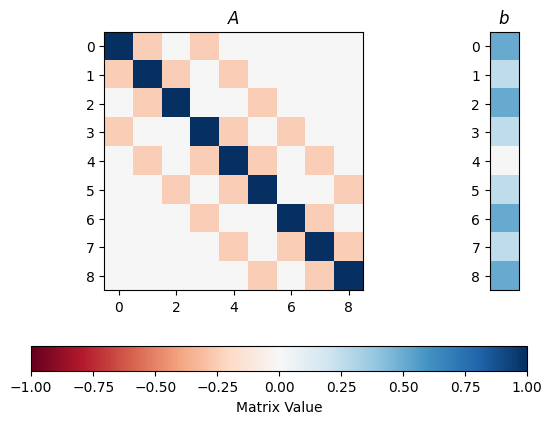

In [7]:
### BEGIN TESTS ###

# First we set up the grid and assemble the matrix.
test_mesh = Grid(5,5)
test_mesh.u[0,:] = 1
test_mesh.u[-1,:] = 1
test_mesh.u[:,0] = 1
test_mesh.u[:,-1] = 1
A, b = assemble_matrix(test_mesh)

# Then we make the figure and make it look nice.
# A similar effect can be achived using plt.spy() but this method allows you to see the values of each matrix element.
A = A.todense()

supmax = np.max([np.max(A), np.max(b), -np.min(A), -np.min(b)])
nrom = Normalize(vmin=-supmax, vmax=supmax)

fig, axs = plt.subplots(1,2,width_ratios=(1+1.85*A.shape[0], 2))

axs[0].imshow(A, aspect='equal', cmap=cm.RdBu, norm=nrom)
axs[1].imshow(np.transpose(np.array([b])), aspect='equal', cmap=cm.RdBu, norm=nrom)

plt.colorbar(cm.ScalarMappable(norm=nrom, cmap=cm.RdBu), ax=axs, orientation='horizontal', label='Matrix Value')

axs[1].set_xticks([])
axs[0].set_title("$A$")
axs[1].set_title("$b$")



plt.show()
### END TESTS ###

Below, we set up a mesh to solve the Laplace equation to determine the electric potential $V(x,y)$ for a 1m x 1m region of space surrounded by charged plates.
The plates are held at the following potentials:

- Left and right plate: $V=1$
- Bottom plate: $V=-1$
- Top plate: $V=0$

We also define a small helper function ``solve_system()`` which unpacks the results of the matrix and puts them back into the grid.
Run the cell below to continue.

In [8]:
matrix_mesh = Grid(201,201)
matrix_mesh.generate(Quiet=True)
matrix_mesh.u[0,:] = 1
matrix_mesh.u[-1,:] = 1
matrix_mesh.u[:,0] = -1
matrix_mesh.u[:,-1] = 0

def solve_system(mesh: Grid, A: sp._lil.lil_matrix , b: np.ndarray) -> None:
    """A helper function to solve the matrix that we have assembled and then unpack the values back into the grid.
    The unpacking is basically the same as what you did in part c) but in reverse this time.
    
    Parameters
    ---------

    mesh: Grid
        The mesh that we are solving the Laplace equation on.
        The solved system will be unpacked back into ``mesh.u``.

    A: scipy.sparse._lil.lil_matrix
        The ``A`` matrix that we have assembled (in sparse form to save memory).
    
    b: np.ndarray
        The ``b`` vector that we have assembled.

    """

    # We start by solving using the Biconjugate Gradient Stabilised Iteration to solve our matrix equation.
    # You don't need to know how this iteration works.
    
    x, _ = sp.linalg.bicgstab(A,b,atol=0.5e-12)

    # Now we unpack x back into our original mesh.

    for j in range(1, mesh.nj-1):
        for i in range(1, mesh.ni-1):
            k = (i-1) + (mesh.ni-2)*(j-1)
            mesh.u[i,j]=x[k]

### f)

Set up the matrix $A$ and vector $\mathbf{b}$ for this system using `assemble_matrix` function. Solve to find the electric potential $V(x,y)$ using the function `solve_system`.
Finally, plot $V(x,y)$.

If you have not been able to complete the ``assemble_matrix()`` function, uncomment the line below that says `from entrypoint import assemble_matrix` to import a completed version.

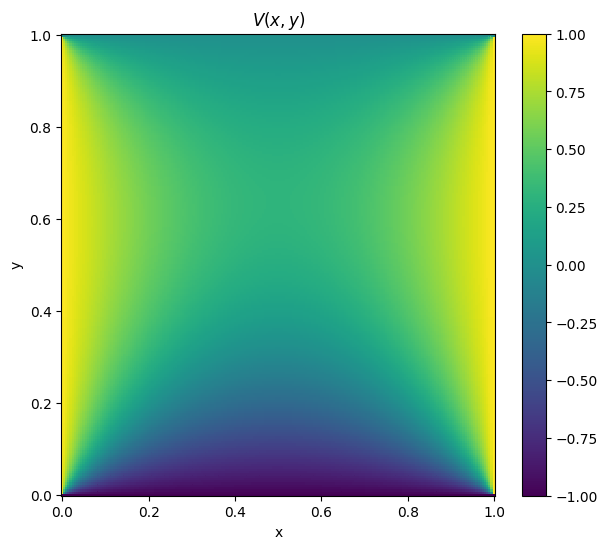

In [9]:
# from entrypoint import assemble_matrix

# Your code here:

### BEGIN SOLUTION ###

A, b = assemble_matrix(mesh= matrix_mesh)

solve_system(mesh = matrix_mesh, A = A, b = b)

plt.figure(figsize=(7,6))
plt.pcolor(matrix_mesh.x, matrix_mesh.y, matrix_mesh.u)
plt.xlabel("x")
plt.ylabel("y")
plt.title("$V(x,y)$")
plt.colorbar()

plt.show()

### END SOLUTION ###

# Section 2: Grid Convergence

In this section, we will explore the effects of mesh size on the convergence of the solution to the Laplace equation.

To do this, we will use the example provided in Lecture 4:

$$
u_{xx} + u_{yy} = 0
$$

with the boundary conditions:

$$
u(x,0) = 0   \;\;\;\;\;\;  {\rm for \;}  0 \le x \le 2 
$$
$$
u(x,1) = 0  \;\;\;\;\;\;   {\rm for \;}  0 \le x \le 2
$$
$$
u(0,y) = 0  \;\;\;\;\;\;   {\rm for \;}  0 \le y \le 1
$$
$$
u(2,y) = \sin (2\pi y)  \;\;\;\;\;\;  {\rm for \;}  0 \le y \le 1
$$


To enable comparison between different grid sizes, we define the following quantity:

$$
U = \int_0^1 \int_0^2 u(x,y) \, dx \, dy
$$

which gives us a single number to compare the solutions.

In the cell below, we provide a list and two numpy arrays.
These contain the sizes of each grid, the grid spacing and the values of $U$ respectively.


In [10]:
# Run this cell to continue; you do not need to modify it.

grid_sizes = [(1281,641), (641,321), (321,161), (161,81), (81,41), (41,21), (21,11), (11,6)]
grid_spacings = np.array([0.00156, 0.00313, 0.00625, 0.0125, 0.025, 0.05, 0.1, 0.2])
Us = np.array([0.0401, 0.0405, 0.0413, 0.0429, 0.0464, 0.0538, 0.0710, 0.112])

There are two ways in which the apparent order of convergence can be calculated.

The first (easier) is to use the formula:

$$
p=\ln \left(\frac{U_3-U_2}{U_2-U_1}\right) / \ln (\frac{\Delta x_2}{\Delta x_1})
$$
with $\Delta x_1 < \Delta x_2$, on the finest three grids.


The second (slightly more involved method) is to fit 

$$
U(\Delta x) = U(\Delta x \rightarrow 0) + C (\Delta x)^p
$$
to the data, with $U(\Delta x \rightarrow 0)$, $C$ and $p$ as the fitting parameters.

Implement one of these methods below to determine the order of convergence. If you choose the second approach, you may find the python function `curve_fit` useful.

In [11]:
# Your code here:

### BEGIN SOLUTION ###

# First, we implement the first method:

def calc_p_1(Us: np.ndarray, spacings: np.ndarray) -> float:
    num = np.log((Us[2]- Us[1])/(Us[1]-Us[0]))
    denom = np.log(spacings[1]/spacings[0])
    return num/denom


p1 = calc_p_1(Us, grid_spacings)

print(f"The value of p using method 1 is {p1:.3f}")


# Now we implement the second method:

def calc_p_2(Us: np.ndarray, spacings: np.ndarray) -> float:
    
    def curve(dx, u0, C, p):
        """A helper function which implements the curve to fit."""
        return u0 + C*dx**p

    popt, _ = curve_fit(curve, spacings[:4], Us[:4])
    return popt[-1], popt[0]

p2,u0 = calc_p_2(Us, grid_spacings)

print(f"The value of p using method 2 is {p2:.3f}")
print(f"The value of U(∆x->0) using method 2 is {u0:.4f}")

### END SOLUTION ###

The value of p using method 1 is 0.995
The value of p using method 2 is 1.001
The value of U(∆x->0) using method 2 is 0.0397


Using Richardson extrapolation, we can find that $U(\Delta x \rightarrow 0) = 0.0398$.

The Grid Convergence Index (GCI) is given by:

$$
GCI_{i,i+1} = \dfrac{F_s |\epsilon_{i,i+1}|}{r^p - 1}
$$

where $\epsilon_{i,i+1} = \dfrac{U(\Delta x_{i+1})-U(\Delta x_{i})}{U(\Delta x_{i})}$, $F_s=1.25$ is the safety factor, $r=\dfrac{\Delta x_{i+1}}{\Delta x_{i}}$ is the ratio of the grid spacings and $p$ is the order of convergence.


Three successive meshes are considered to be in the asymptotic range when

$$
\dfrac{GCI_{i+1,i+2}}{r^p GCI_{i,i+1}} \approx 1
$$


### b)

Determine the Grid Convergence Index for each pair of successive grids and hence determine which grids are in the asymptotic range.

In [12]:
# Your code here:

### BEGIN SOLUTION ###
epsilons = (Us[1:] - Us[:-1])/Us[:-1]

GCIs = 1.25*epsilons/((grid_spacings[1:]/grid_spacings[:-1])**p2-1)

ratios = GCIs[1:]/(2**p2*GCIs[:-1])
ratios = np.append(ratios, np.nan)


grids = np.arange(1, len(grid_sizes))

print("| Grid |  GCI  | Ratio |")
print("------------------------")
for i in range(len(grids)):
    print(f"|{grids[i]:6.4g}|{GCIs[i]:7.3g}|{ratios[i]:7.4g}|")

### END SOLUTION ###

| Grid |  GCI  | Ratio |
------------------------
|     1| 0.0124| 0.9989|
|     2| 0.0247| 0.9767|
|     3| 0.0483|  1.052|
|     4|  0.102| 0.9766|
|     5|  0.199|  1.001|
|     6|  0.399| 0.9024|
|     7|  0.721|    nan|
